# Prepare Basin Averaged Forcing for NGEN using Pre-computed Weights

**Authors:**  
   - Tony Castronova <acastronova@cuahsi.org>    
   - Irene Garousi-Nejad <igarousi@cuahsi.org>  
    
<!-- **Last Updated:** 06.21.2023   

**Description**:  

The purpose of this Jupyter Notebook is to demonstrate how to prepare basin averaged forcing input from for the [NOAA Next Generation (NextGen) Water Resource Modeling Framework](https://github.com/NOAA-OWP/ngen). This notebook demonstrates how these data can be prepared from AORC **v1.0** kerchunk header files.

**Link to data**:
- Original: https://noaa-nwm-retrospective-2-1-pds.s3.amazonaws.com/index.html#forcing/
- Kerchunk: https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/index.html#noaa-nwm-retrospective-2-1-zarr-pds/

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

Tested on: Windows (`python: 3.9.16`) 

> dask: 2023.5.1 \
  numpy: 1.24.3 \
    xarray: 2023.5.0 \
    pyproj: 3.5.0 \
    pandas: 2.0.2 \
    requests: 2.31.0 \
    geopandas: 0.13.2 \
    matplotlib: 3.7.1 \
    zarr: 2.15.0 \
    fsspec: 2023.6.0 \
    s3fs: 2023.6.0 \
    kerchunk:0.1.2 
    
--- -->

In [1]:
import re
import dask
import numpy
import xarray
import pyproj
import pandas
import requests
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import progress

import zarr
import fsspec
from pyproj import Transformer
from s3fs import S3FileSystem
from kerchunk.combine import MultiZarrToZarr

In [2]:
import rioxarray
from geocube.api.core import make_geocube

Initiate the Dask client. This will enable us to parallelize our computations.

In [3]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=2, memory_limit='2GB') # per worker
    print(client.dashboard_link)


http://127.0.0.1:8787/status


---

## Load Forcing Data into Memory

In this notebook we'll be working with AORC v1.0 meteorological forcing. These data are publicly available for the entire CONUS, spanning from 1980 to 2020. Kerchunk header files have been created by the Alabama Water Institute team and this is an ongoing project. Please note that this jupyter notebook works for data within 2007-2019, but it cannot work with data prior to 2006.  

In [69]:
# define the selected watershed boundary 
wb_id = 'wb-2851655'

# define the year of interest
year=2010

In [70]:
bucket = 's3://ciroh-nwm-zarr-retrospective-data-copy/noaa-nwm-retrospective-2-1-zarr-pds/forcing/'

# create an instace of the S3FileSystem class from s3fs
s3 = S3FileSystem(anon=True)
files = s3.ls(f'{bucket}{year}')  

new_files = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    new_files.append(new_name)
    

In [71]:
print(len(new_files))
new_files[0]

8760


'https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/noaa-nwm-retrospective-2-1-zarr-pds/forcing/2010/2010010100.LDASIN_DOMAIN1.json'

Considering the memory limitations, it is necessary to choose a smaller subset of the dataset. Afterwards, we can utilize the `MultiZarrToZarr` function from the kerchunk library to merge the individual header files and generate a single kerchunk file.

In [72]:
%%time
json_list = new_files[0:217] 

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['valid_time'])

d = mzz.translate()

backend_args = {"consolidated": False, "storage_options": {"fo": d}, "consolidated": False}

ds = xarray.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

CPU times: user 1.32 s, sys: 310 ms, total: 1.63 s
Wall time: 2.04 s


In [73]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:     (valid_time: 217, Time: 1, south_north: 3840, west_east: 4608)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    LWDOWN      (valid_time, Time, south_north, west_east) float32 15GB ...
    PSFC        (valid_time, Time, south_north, west_east) float32 15GB ...
    Q2D         (valid_time, Time, south_north, west_east) float32 15GB ...
    RAINRATE    (valid_time, Time, south_north, west_east) float32 15GB ...
    SWDOWN      (valid_time, Time, south_north, west_east) float32 15GB ...
    T2D         (valid_time, Time, south_north, west_east) float32 15GB ...
    Times       (valid_time) |S20 4kB ...
    U2D         (valid_time, Time, south_north, west_east) float32 15GB ...
    V2D         (valid_time, Time, south_north, west_east) float32 15GB ...

In [74]:
ds.valid_time

<xarray.DataArray 'valid_time' (valid_time: 217)> Size: 2kB
array(['2010-01-01T00:00:00.000000000', '2010-01-01T01:00:00.000000000',
       '2010-01-01T02:00:00.000000000', ..., '2010-01-09T22:00:00.000000000',
       '2010-01-09T23:00:00.000000000', '2010-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10

Use SQUEEZE function to remove the Time dimension that has a size of 1 .

In [75]:
ds = ds.squeeze(dim='Time')

In [76]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:     (valid_time: 217, south_north: 3840, west_east: 4608)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
Dimensions without coordinates: south_north, west_east
Data variables:
    LWDOWN      (valid_time, south_north, west_east) float32 15GB ...
    PSFC        (valid_time, south_north, west_east) float32 15GB ...
    Q2D         (valid_time, south_north, west_east) float32 15GB ...
    RAINRATE    (valid_time, south_north, west_east) float32 15GB ...
    SWDOWN      (valid_time, south_north, west_east) float32 15GB ...
    T2D         (valid_time, south_north, west_east) float32 15GB ...
    Times       (valid_time) |S20 4kB ...
    U2D         (valid_time, south_north, west_east) float32 15GB ...
    V2D         (valid_time, south_north, west_east) float32 15GB ...

## Add spatial metadata to the dataset 


Load the metadata dataset using `xarray` and add spatial metadata to it.

In [16]:
!wget https://thredds.hydroshare.org/thredds/fileServer/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc

--2024-03-20 16:13:52--  https://thredds.hydroshare.org/thredds/fileServer/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc
Resolving thredds.hydroshare.org (thredds.hydroshare.org)... 152.54.1.137
Connecting to thredds.hydroshare.org (thredds.hydroshare.org)|152.54.1.137|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 74957 (73K) [application/x-netcdf]
Saving to: ‘WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc’

WRF_Hydro_NWM_geosp 100%[===================>]  73.20K  --.-KB/s    in 0.05s   

2024-03-20 16:13:52 (1.40 MB/s) - ‘WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc’ saved [74957/74957]



In [77]:
#ds_meta = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')
ds_meta = xarray.open_dataset('WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')
leny = len(ds_meta.y)
x = ds_meta.x.values
y = ds_meta.y.values

ds = ds.rename({'valid_time': 'time', 'south_north':'y', 'west_east':'x'})
#ds.rename_dims(south_north='y', west_east='x', valid_time='time')

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000)

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True);


In [78]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:      (time: 217, y: 3840, x: 4608)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 142MB -133.5 -133.5 -133.5 ... -75.9 -75.9
    lat          (y, x) float64 142MB 52.87 52.88 52.88 ... 20.08 20.08 20.08
  * x            (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y            (y) float64 31kB 1.919e+06 1.918e+06 ... -1.919e+06 -1.92e+06
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 15GB ...
    PSFC         (time, y, x) float32 15GB ...
    Q2D          (time, y, x) float32 15GB ...
    RAINRATE     (time, y, x) float32 15GB ...
    SWDOWN       (time, y, x) float32 15GB ...
    T2D          (time, y, x) float32 15GB ...
    Times        (time) |S20 4kB ...
    U2D          (time, y, x) float32 15GB ...
    V2D          (time, y, x) float32 15GB ...

## Add spatial reference to the model domain

Load the geodatabase of our `ngen` domain. This can be obtained using the `ngen-hydrofabric-subset.ipynb` notebook.

In [14]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'domain/v20.1/{wb_id}/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')

gdf['geometry'].values

<GeometryArray>
[<POLYGON ((-1278615 2213175, -1278705 2213205, -1278885 2213205, -1278945 22...>,
 <POLYGON ((-1279245 2214315, -1279335 2214315, -1279455 2214375, -1279485 22...>,
 <POLYGON ((-1282665 2215305, -1282785 2215395, -1282785 2215635, -1282755 22...>,
 <POLYGON ((-1282725 2217135, -1282695 2217165, -1282695 2217435, -1282545 22...>,
 <POLYGON ((-1275435 2217795, -1275525 2217795, -1275795 2218095, -1275885 22...>,
 <POLYGON ((-1282965 2212095, -1282965 2212245, -1282875 2212395, -1282875 22...>,
 <POLYGON ((-1277355 2211765, -1277445 2211525.001, -1277445 2211525, -127747...>,
 <POLYGON ((-1277445 2211285, -1277475 2211435, -1277475 2211465, -1277445 22...>,
 <POLYGON ((-1280325 2211375, -1280355 2211405, -1280355 2211675, -1280325 22...>,
 <POLYGON ((-1279605 2208945, -1279785 2209065, -1280115 2209155, -1280235 22...>,
 ...
 <POLYGON ((-1296825 2178015, -1296825 2178075, -1296615 2178105, -1296555 21...>,
 <POLYGON ((-1293225 2175795, -1293495 2175855, -1293615 2176005, 

In [15]:
# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

gdf['geometry'].values

<GeometryArray>
[<POLYGON ((-1161773.06 318840.189, -1161860.009 318870.783, -1162034.858 318...>,
 <POLYGON ((-1162366.926 319948.848, -1162454.349 319950.588, -1162569.959 32...>,
 <POLYGON ((-1165673.2 320967.329, -1165788.326 321056.224, -1165784.493 3212...>,
 <POLYGON ((-1165702.248 322728.636, -1165672.63 322756.909, -1165668.315 323...>,
 <POLYGON ((-1158610.994 323222.515, -1158698.409 323224.247, -1158955.903 32...>,
 <POLYGON ((-1166015.842 317885.692, -1166013.45 318029.966, -1165923.63 3181...>,
 <POLYGON ((-1160571.445 317459.691, -1160662.671 317230.589, -1160662.671 31...>,
 <POLYGON ((-1160666.471 316999.75, -1160693.239 317144.603, -1160692.764 317...>,
 <POLYGON ((-1163462.746 317141.974, -1163491.413 317171.41, -1163487.122 317...>,
 <POLYGON ((-1162801.874 314790.8, -1162974.836 314909.703, -1163293.995 3150...>,
 ...
 <POLYGON ((-1180029.307 285377.746, -1180028.346 285435.458, -1179823.712 28...>,
 <POLYGON ((-1176564.878 283171.423, -1176826.417 283234.447, -117

In [16]:
# important step
# rechunk the dataset to solve the memory limit issue
ds = ds.chunk(chunks={'time': 1})

## Clip AORC to the extent of the subset hydrofabric geometries

In [17]:
ds_bak = ds.copy(deep=True)

Add catchment ids to the geodataset. These will be used to perform zonal statistics later on.

In [18]:
ds = ds_bak.copy(deep=True)

In [19]:
%%time

# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

# clip AORC to the extent of the hydrofabric geometries
ds = ds.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

# select a single array of data to use as a template
lwdown_data = ds.isel(time=0).LWDOWN

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=ds # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
ds = ds.assign_coords(cat = (['y','x'], out_grid.cat.data))

# compute the unique catchment IDs which will be used to compute zonal statistics
catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

print(f'The dataset contains {len(catchment_ids)} catchments')

The dataset contains 186 catchments
CPU times: user 2.53 s, sys: 219 ms, total: 2.75 s
Wall time: 2.71 s


In [20]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:      (time: 217, y: 69, x: 36)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 20kB dask.array<chunksize=(69, 36), meta=np.ndarray>
    lat          (y, x) float64 20kB dask.array<chunksize=(69, 36), meta=np.ndarray>
  * x            (x) float64 288B -1.186e+06 -1.185e+06 ... -1.151e+06
  * y            (y) float64 552B 3.315e+05 3.305e+05 ... 2.645e+05 2.635e+05
    spatial_ref  int64 8B 0
    cat          (y, x) float64 20kB nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    LWDOWN       (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    PSFC         (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    Q2D          (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    T2D          (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    Times        (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>
    V2D          (time, y, x) float32 2MB dask.array<chunksize=(1, 69, 36), meta=np.ndarray>

## Preview the gridded catchments over the watershed vector boundary

Note that the method we're using will associate grid cell with the watershed that it overlaps the most with. There are more advanced ways to create a mapping using various interpolation methods that will distribute values cells across all watershed boundaries that they intersect with. This is left as a future exercize. 

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 287.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


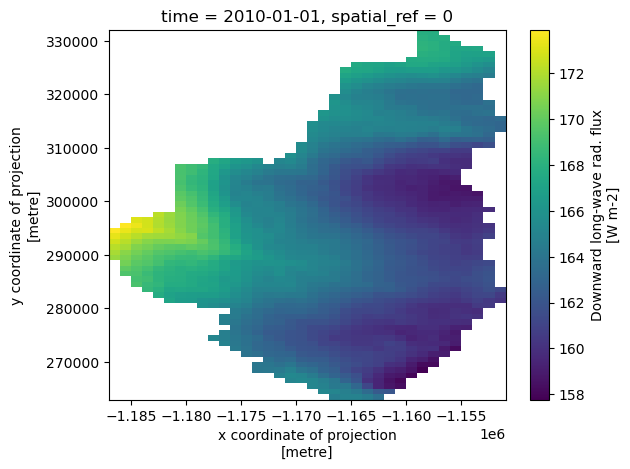

In [21]:
ds.isel(time=0).LWDOWN.plot()

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


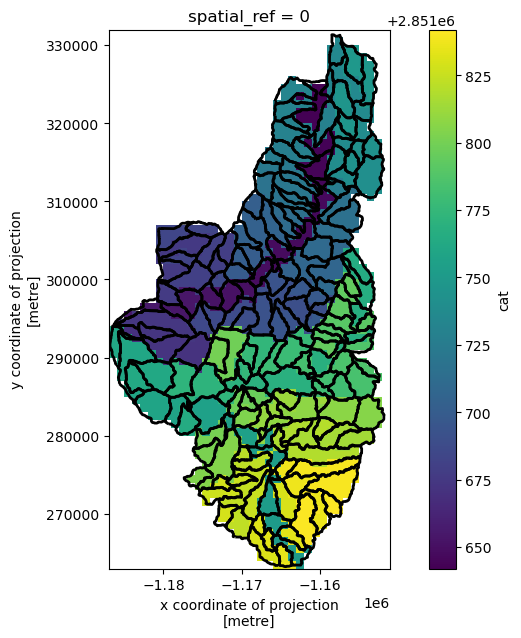

In [22]:
figure, ax = plt.subplots(figsize=(10,7))


# plot the gridded catchment mapping
ds.cat.plot()

# preview map geometries
gdf.iloc[:].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');


### Build Weights Grid Map

- compute cell center point for all grids in catchment
- compute cell number using algorithm:
- snap cell number to nearest cell number in weights file.

TODO:
- do this for all grids and save for use later on in way that can be joined into the AORC data.

In [180]:
!wget 'https://lynker-spatial.s3.amazonaws.com/v20.1/forcing_grids.json'

--2024-03-21 09:49:58--  https://lynker-spatial.s3.amazonaws.com/v20.1/forcing_grids.json
Resolving lynker-spatial.s3.amazonaws.com (lynker-spatial.s3.amazonaws.com)... 52.218.197.99, 52.92.233.169, 52.218.237.211, ...
Connecting to lynker-spatial.s3.amazonaws.com (lynker-spatial.s3.amazonaws.com)|52.218.197.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283 [application/json]
Saving to: ‘forcing_grids.json’

forcing_grids.json  100%[===================>]     283  --.-KB/s    in 0.002s  

2024-03-21 09:49:59 (124 KB/s) - ‘forcing_grids.json’ saved [283/283]



In [23]:
import json
wgrid = json.load(open('forcing_grids.json', 'r'))
wgrid

[{'grid_id': 'medium_range.forcing.conus',
  'schema': 'climateR',
  'X1': -2303999.25,
  'Xn': 2304000.75,
  'Y1': -1920000.375,
  'Yn': 1919999.625,
  'resX': 1000,
  'resY': 1000,
  'ncols': 4608,
  'nrows': 3840,
  'crs': '+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'}]

In [24]:
xmin = wgrid[0]['X1']
xmax = wgrid[0]['Xn']
ymin = wgrid[0]['Y1']
ymax = wgrid[0]['Yn']
dx = wgrid[0]['resX']
dy = wgrid[0]['resY']
ncols = wgrid[0]['ncols']

In [68]:
ds_bak = ds.copy(deep=True)

In [27]:
numpy.unique(ds.cat.values)

array([2851642., 2851643., 2851644., 2851645., 2851646., 2851647.,
       2851648., 2851649., 2851650., 2851651., 2851652., 2851653.,
       2851654., 2851655., 2851670., 2851671., 2851672., 2851673.,
       2851674., 2851675., 2851676., 2851677., 2851678., 2851679.,
       2851680., 2851681., 2851682., 2851683., 2851684., 2851685.,
       2851686., 2851687., 2851688., 2851689., 2851690., 2851691.,
       2851692., 2851693., 2851694., 2851695., 2851696., 2851697.,
       2851698., 2851699., 2851700., 2851701., 2851702., 2851703.,
       2851704., 2851705., 2851706., 2851707., 2851708., 2851709.,
       2851710., 2851711., 2851712., 2851713., 2851714., 2851715.,
       2851716., 2851717., 2851718., 2851719., 2851720., 2851721.,
       2851722., 2851723., 2851724., 2851725., 2851726., 2851727.,
       2851728., 2851729., 2851730., 2851731., 2851732., 2851733.,
       2851734., 2851735., 2851736., 2851737., 2851738., 2851739.,
       2851740., 2851741., 2851742., 2851743., 2851744., 28517

In [28]:
cat_id = 2851705
ds_catchment = ds.where(ds.cat==cat_id, drop=True)

In [35]:
ds_catchment

<xarray.Dataset> Size: 54kB
Dimensions:      (time: 217, y: 3, x: 2)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
    lat          (y, x) float64 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
  * x            (x) float64 16B -1.164e+06 -1.163e+06
  * y            (y) float64 24B 3.025e+05 3.015e+05 3.005e+05
    spatial_ref  int64 8B 0
    cat          (y, x) float64 48B 2.852e+06 2.852e+06 ... 2.852e+06 2.852e+06
Data variables:
    LWDOWN       (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    PSFC         (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    Q2D          (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    T2D          (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    Times        (time, y, x) object 10kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    U2D          (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>
    V2D          (time, y, x) float32 5kB dask.array<chunksize=(1, 3, 2), meta=np.ndarray>

In [57]:
# get list of x,y projected points associated with this catchment
dd = ds_catchment.isel(time=0)
pts = []
for ix in range(0, len(dd.x)):
    for iy in range(0, len(dd.y)):
        dat = dd.isel(x=ix, y=iy)
        pts.append([dat.x.item(), dat.y.item()])
pts

[[-1164499.125, 302499.65625],
 [-1164499.125, 301499.65625],
 [-1164499.125, 300499.65625],
 [-1163499.125, 302499.65625],
 [-1163499.125, 301499.65625],
 [-1163499.125, 300499.65625]]

In [58]:
# compute cell number
cell_number = (ymax - pts[0][1]) / dy * ncols + (pts[0][0] - xmin) / dx

In [59]:
cell_number

7454579.356125001

In [61]:
# read weights and verify that these cell numbers exist in the parquet file
weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

In [65]:
weights.loc[weights.divide_id == f'cat-{cat_id}']

,divide_id,cell,coverage_fraction,grid_id
13796086,cat-2851705,7452275.0,0.239241,medium_range.forcing.conus
13796087,cat-2851705,7452276.0,0.464558,medium_range.forcing.conus
13796088,cat-2851705,7452277.0,0.374510,medium_range.forcing.conus
13796089,cat-2851705,7456883.0,0.178932,medium_range.forcing.conus
13796090,cat-2851705,7456884.0,0.983314,medium_range.forcing.conus
13796091,cat-2851705,7456885.0,0.986789,medium_range.forcing.conus
13796092,cat-2851705,7456886.0,0.240772,medium_range.forcing.conus
13796093,cat-2851705,7461491.0,0.035560,medium_range.forcing.conus
13796094,cat-2851705,7461492.0,0.725238,medium_range.forcing.conus
13796095,cat-2851705,7461493.0,0.980662,medium_range.forcing.conus


### Test unraveling the weights to see if it's the same shape as our data

In [130]:
def assert_grids_equal(ds, weights_grid):
    dsx = ds.x.resolution
    dsy = ds.y.resolution
    assert dsx == weights_grid[0]['resX']
    assert dsy == weights_grid[0]['resY']
    
    assert ds.x.min().item() - dsx / 2 == weights_grid[0]['X1']
    assert ds.x.max().item() + dsx / 2 == weights_grid[0]['Xn']
    assert ds.y.min().item() - dsy / 2 == weights_grid[0]['Y1']
    assert ds.y.max().item() + dsy / 2 == weights_grid[0]['Yn']
    
    
    ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]
    assert ds_ncols   == weights_grid[0]['ncols']
    assert ds_nrows   == weights_grid[0]['nrows']

    #ds_wkt = ds.spatial_ref.crs_wkt
    #crs = wgrid[0]['crs']

    return True


In [131]:
wgrid = json.load(open('forcing_grids.json', 'r'))
assert_grids_equal(ds, wgrid)

True

In [137]:
# Since our data are the same shape, compute cell indice for all x,y coords

xs = ds.x.values
ys = ds.y.values
dx = ds.x.resolution
dy = ds.y.resolution
xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2 
ymin = ds.y.min().item() - dy / 2 
ymax = ds.y.max().item() + dy / 2 
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]




ValueError: operands could not be broadcast together with shapes (3840,) (4608,) 

In [160]:
# unravel x, y coordinates into point pairs

rr, cc = numpy.meshgrid(xs, ys)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

In [165]:
xss = pair_pts[:,0]
yss = pair_pts[:,1]

In [184]:
cell_number = (ymax - yss) / dy * ncols + (xss - xmin) / dx

In [185]:
cell_ids = cell_number.reshape(ds_nrows, ds_ncols)
cell_ids.shape

(3840, 4608)

In [186]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:      (time: 217, y: 3840, x: 4608)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 142MB -133.5 -133.5 -133.5 ... -75.9 -75.9
    lat          (y, x) float64 142MB 52.87 52.88 52.88 ... 20.08 20.08 20.08
  * x            (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y            (y) float64 31kB 1.919e+06 1.918e+06 ... -1.919e+06 -1.92e+06
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 15GB ...
    PSFC         (time, y, x) float32 15GB ...
    Q2D          (time, y, x) float32 15GB ...
    RAINRATE     (time, y, x) float32 15GB ...
    SWDOWN       (time, y, x) float32 15GB ...
    T2D          (time, y, x) float32 15GB ...
    Times        (time) |S20 4kB ...
    U2D          (time, y, x) float32 15GB ...
    V2D          (time, y, x) float32 15GB ...

In [187]:
ds['cell_number']=(['y','x'], cell_ids)

In [188]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:      (time: 217, y: 3840, x: 4608)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 142MB -133.5 -133.5 -133.5 ... -75.9 -75.9
    lat          (y, x) float64 142MB 52.87 52.88 52.88 ... 20.08 20.08 20.08
  * x            (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y            (y) float64 31kB 1.919e+06 1.918e+06 ... -1.919e+06 -1.92e+06
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 15GB ...
    PSFC         (time, y, x) float32 15GB ...
    Q2D          (time, y, x) float32 15GB ...
    RAINRATE     (time, y, x) float32 15GB ...
    SWDOWN       (time, y, x) float32 15GB ...
    T2D          (time, y, x) float32 15GB ...
    Times        (time) |S20 4kB ...
    U2D          (time, y, x) float32 15GB ...
    V2D          (time, y, x) float32 15GB ...
    cell_number  (y, x) float64 142MB 2.304e+03 6.912e+03 ... 1.769e+07 1.77e+07

In [191]:
# test using cell_number to compute weights
cat_id = 2851705
ds_catchment = ds.where(ds.cat==cat_id, drop=True)


AttributeError: 'Dataset' object has no attribute 'cat'

In [213]:
cell_number

array([8201037.356125, 8205646.356125, 8210255.356125, 8214864.356125,
       8219473.356125])

In [190]:
gdf.loc[gdf.divide_id == f'cat-{2851705}']

,id,divide_id,toid,type,ds_id,areasqkm,lengthkm,tot_drainage_areasqkm,has_flowline,geometry,cat
53,cat-2851705,cat-2851705,nex-2851649,network,None,6.02955,4.949371,6.02955,True,"POLYGON ((-1163022.554 299583.664, -1163136.80...",2851705


In [62]:
# # read weights and verify that these cell numbers exist in the parquet file
# weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

In [63]:
# weights.loc[weights.divide_id == 'cat-2917533']

In [64]:
# weights

### Testing Jordan Lazer's code

In [94]:
import pyarrow as pa
import pyarrow.compute as pc
import pyarrow.dataset

In [114]:
catchments = ds['cat'].values
catchments = set(catchments[~numpy.isnan(catchments)].flatten())

In [117]:
weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

In [120]:
catchments

{2917496.0,
 2917497.0,
 2917498.0,
 2917499.0,
 2917500.0,
 2917501.0,
 2917502.0,
 2917503.0,
 2917504.0,
 2917505.0,
 2917506.0,
 2917507.0,
 2917508.0,
 2917509.0,
 2917510.0,
 2917511.0,
 2917512.0,
 2917513.0,
 2917514.0,
 2917515.0,
 2917516.0,
 2917517.0,
 2917518.0,
 2917519.0,
 2917522.0,
 2917523.0,
 2917524.0,
 2917525.0,
 2917527.0,
 2917528.0,
 2917530.0,
 2917531.0,
 2917532.0,
 2917533.0,
 2917601.0,
 2917602.0,
 2917603.0,
 2917604.0,
 2917605.0,
 2917606.0,
 2917607.0,
 2917608.0,
 2917609.0,
 2917627.0,
 2917628.0,
 2917629.0,
 2917630.0,
 2917631.0,
 2917661.0,
 2917662.0,
 2917663.0,
 2917664.0,
 2917665.0,
 2917666.0,
 2917667.0,
 2917699.0,
 2917700.0,
 2917701.0,
 2917702.0,
 2917715.0,
 2917716.0,
 2917717.0,
 2917718.0,
 2917719.0,
 2917720.0,
 2917721.0,
 2917722.0,
 2917723.0,
 2917729.0,
 2917730.0,
 2917731.0,
 2917753.0,
 2917754.0,
 2917755.0,
 2917756.0,
 2917757.0,
 2917758.0,
 2917759.0,
 2917760.0,
 2917761.0,
 2917762.0,
 2917763.0,
 2917768.0,
 291

In [118]:
weights

,divide_id,cell,coverage_fraction,grid_id
0,cat-277,4667799.0,0.017426,medium_range.forcing.conus
1,cat-277,4667800.0,0.187463,medium_range.forcing.conus
2,cat-277,4667801.0,0.106564,medium_range.forcing.conus
3,cat-277,4672405.0,0.000846,medium_range.forcing.conus
4,cat-277,4672406.0,0.221390,medium_range.forcing.conus
...,...,...,...,...
16388409,cat-3287502,10437436.0,0.012160,medium_range.forcing.conus
16388410,cat-3287502,10437437.0,0.768893,medium_range.forcing.conus
16388411,cat-3287502,10437438.0,0.264827,medium_range.forcing.conus
16388412,cat-3287502,10442044.0,0.013715,medium_range.forcing.conus


In [122]:
catchment_list = list(weights.divide_id.unique())

In [125]:
import time
def get_weight_json(catchments,version,nprocs):
    if version is None: version = "v20.1"
    print(f'Beginning weights query')
    w = pa.dataset.dataset(
        f's3://lynker-spatial/{version}/forcing_weights.parquet', format='parquet'
    ).filter(
        pc.field('divide_id').isin(catchments)
    ).to_batches()
    batch: pa.RecordBatch
    t_weights = time.perf_counter()    
    count = 0
    ncatchments = len(catchments)
    print(f'Querying weights for {ncatchments} catchments',flush=True)
    proc_pairs = []
    for batch in w:
        count += 1
        tbl = batch.to_pandas()
        if tbl.empty:
            continue    
        uni_cat = tbl.divide_id.unique()    
        located = [x for x in catchments if x in uni_cat]  
        if len(located) > 0:
            proc_pairs.append([tbl,located])
            print(f'found {len(located)} in batch {count}',flush=True)

    print(f'Weights have been retrieved, converting from tabular to per-catchment json for forcingprocessor',flush=True)
    npairs = len(proc_pairs)
    nprocs = min(os.cpu_count(), nprocs, npairs)
    proc_pairs_list = []    
    nper = npairs // nprocs
    nleft = npairs - (nper * nprocs)
    i = 0
    k = 0
    for j in range(nprocs):
        k = nper + i + nleft      
        proc_pairs_list.append(proc_pairs[i:k])
        i = k

    with cf.ProcessPoolExecutor(max_workers=nprocs) as pool:
        results = pool.map(get_catchment_idx,proc_pairs_list)

    weights = {}
    for jweights in results:
        weights = weights | jweights           
    
    nweights = len(weights)
    assert nweights == ncatchments, f'nweights {nweights} does not equal ncatchments {ncatchments}!!'

    print(f'Weights calculated for {nweights} catchments in {time.perf_counter() - t_weights:.1f} seconds',flush=True)

    return weights

In [128]:
ds

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 217, y: 47, x: 75)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 28kB dask.array<chunksize=(47, 75), meta=np.ndarray>
    lat          (y, x) float64 28kB dask.array<chunksize=(47, 75), meta=np.ndarray>
  * x            (x) float64 600B -1.203e+06 -1.202e+06 ... -1.13e+06 -1.129e+06
  * y            (y) float64 376B 1.805e+05 1.795e+05 ... 1.355e+05 1.345e+05
    spatial_ref  int64 8B 0
    cat          (y, x) float64 28kB nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    LWDOWN       (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    PSFC         (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    Q2D          (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    T2D          (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    Times        (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>
    V2D          (time, y, x) float32 3MB dask.array<chunksize=(1, 47, 75), meta=np.ndarray>

In [137]:
catchments = ds['cat'].values
catchments = list(set(catchments[~numpy.isnan(catchments)].flatten()))
catchments = [f'cat-{int(c)}' for c in catchments]

In [136]:
weights

,divide_id,cell,coverage_fraction,grid_id
0,cat-277,4667799.0,0.017426,medium_range.forcing.conus
1,cat-277,4667800.0,0.187463,medium_range.forcing.conus
2,cat-277,4667801.0,0.106564,medium_range.forcing.conus
3,cat-277,4672405.0,0.000846,medium_range.forcing.conus
4,cat-277,4672406.0,0.221390,medium_range.forcing.conus
...,...,...,...,...
16388409,cat-3287502,10437436.0,0.012160,medium_range.forcing.conus
16388410,cat-3287502,10437437.0,0.768893,medium_range.forcing.conus
16388411,cat-3287502,10437438.0,0.264827,medium_range.forcing.conus
16388412,cat-3287502,10442044.0,0.013715,medium_range.forcing.conus


In [159]:
%%time

# w = pa.dataset.dataset(
#         f's3://lynker-spatial/v20.1/forcing_weights.parquet', format='parquet'
#     ).filter(
#         pc.field('divide_id').isin(catchments)
#     ).to_batches()

w = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet',
                        filters=[('divide_id', 'in', ['cat-3287502', 'cat-277'])])

CPU times: user 3.61 s, sys: 2.24 s, total: 5.85 s
Wall time: 55.3 s


In [163]:
df_jcatch = w.loc[w.divide_id == 'cat-277']

In [164]:
idx_list = [int(x) for x in list(df_jcatch['cell'])]

In [166]:
df_catch = list(df_jcatch['coverage_fraction'])

In [177]:
weights = {}
weights['cat-277'] = [idx_list,df_catch]

In [153]:
catchments

['cat-2918213',
 'cat-2918214',
 'cat-2917933',
 'cat-2917934',
 'cat-2917935',
 'cat-2917936',
 'cat-2917937',
 'cat-2917938',
 'cat-2917939',
 'cat-2917940',
 'cat-2917941',
 'cat-2917942',
 'cat-2917943',
 'cat-2917944',
 'cat-2917945',
 'cat-2917946',
 'cat-2917947',
 'cat-2917948',
 'cat-2917949',
 'cat-2917950',
 'cat-2918215',
 'cat-2917951',
 'cat-2918206',
 'cat-2918271',
 'cat-2917496',
 'cat-2917497',
 'cat-2917498',
 'cat-2917499',
 'cat-2917500',
 'cat-2917501',
 'cat-2917502',
 'cat-2917503',
 'cat-2917504',
 'cat-2917505',
 'cat-2917506',
 'cat-2917507',
 'cat-2918020',
 'cat-2918021',
 'cat-2917510',
 'cat-2917511',
 'cat-2917512',
 'cat-2917513',
 'cat-2917514',
 'cat-2917515',
 'cat-2917516',
 'cat-2917509',
 'cat-2917517',
 'cat-2917518',
 'cat-2917519',
 'cat-2918033',
 'cat-2917522',
 'cat-2917523',
 'cat-2917524',
 'cat-2918034',
 'cat-2918038',
 'cat-2918039',
 'cat-2918040',
 'cat-2918041',
 'cat-2918042',
 'cat-2918043',
 'cat-2918044',
 'cat-2918045',
 'cat-29

In [152]:
w

,divide_id,cell,coverage_fraction,grid_id


In [148]:
%%time 

batch: pa.RecordBatch
count = 0
ncatchments = len(catchments)
print(f'Querying weights for {ncatchments} catchments',flush=True)
proc_pairs = []
for batch in w:
    count += 1
    tbl = batch.to_pandas()
    if tbl.empty:
        continue    
    uni_cat = tbl.divide_id.unique()    
    located = [x for x in catchments if x in uni_cat]  
    if len(located) > 0:
        proc_pairs.append([tbl,located])
        print(f'found {len(located)} in batch {count}',flush=True)
print(f'Weights have been retrieved, converting from tabular to per-catchment json for forcingprocessor',flush=True)
npairs = len(proc_pairs)

Querying weights for 244 catchments
Weights have been retrieved, converting from tabular to per-catchment json for forcingprocessor
CPU times: user 3.45 s, sys: 2.21 s, total: 5.66 s
Wall time: 48.6 s


In [149]:
npairs

0

In [126]:
w = get_weight_json(catchment_list,None, 2)

Beginning weights query
Querying weights for 817573 catchments


KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
2024-03-20 17:01:02,159 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-03-20 17:01:02,161 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/base_events.py", line 685, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/nanny.py", line 983, in run
    await worker.finished()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/core.py", lin

## Compute basin-averaged forcing data

Define functions that will be used to perform basin averages on the AORC data. These functions leverage `dask` to parallelize the computation.

In [ ]:
# call once per catchment
# distribute zonal stats to sub processes
def perform_zonal_computation(ds, cat_id):

    # subset by catchment id
    ds_catchment = ds.where(ds.cat==cat_id, drop=True)
#    ds_catchement_future = client.scatter(ds_catchment, broadcast=True)
    
    delayed = []
    # loop over variables   
    for variable in ['LWDOWN', 'PSFC',
                     'Q2D', 'RAINRATE', 'SWDOWN',
                     'T2D', 'U2D', 'V2D']:
                
        delay = dask.delayed(compute_zonal_mean)(ds_catchment[variable], variable)
        delayed.append(delay)
        
    res = dask.compute(*delayed)
    
    # combine outputs (list of dicts) into a single dict.
    res = {k: v for d in res for k, v in d.items()}
    
    # return results
    return {f'cat-{int(cat_id)}': res}

def compute_zonal_mean(ds, variable):
    return {variable: ds.mean(dim=['x','y']).values}

Slice the data to the temporal period of our choice.

In [ ]:
# define the start and end time of the data we want to use
start_time = f'{year}-01-01 00:00'
end_time = f'{year}-01-10 00:00'

# isolate the desired time period of our data
ds_subset = ds.sortby('time').sel(time=slice(start_time, end_time))

print(f'The dataset contains {len(ds_subset.time)} timesteps')

Let's rechunk our data now that we have many fewer elements.

In [ ]:
ds_subset = ds_subset.chunk(chunks={'time': 1000})

In [ ]:
ds_subset.chunks

Drop all data that we don't need. The goal here is to make the dataset as small as possible before we start running computations on the data.

In [ ]:
# drop unused coordinates
ds_subset = ds_subset.drop(['lat','lon'])

Tell `dask` to perform the subsetting computations on the data now. That way when we process the zonal statistics, the entire dataset won't need to be moved around. This will save a considerable amount of processing in future steps time.

In [ ]:
%%time 
ds_subset = ds_subset.compute()

In [ ]:
ds_subset

Scatter the dataset to the cluster so all workers will have access to it. This is good practice and especially necessary if working on a large dataset.

In [ ]:
%%time
scattered_ds = client.scatter(ds_subset, broadcast=True)

Build a list of `delayed` tasks. This will not execute the computation.

In [ ]:
%%time
delayed = []

# loop over each catchment in our domain
# create delayed tasks to compute zonal mean
for cat_id in catchment_ids:
    delay = dask.delayed(perform_zonal_computation)(scattered_ds, cat_id)
    delayed.append(delay)

Invoke the computation using `dask.compute`.

In [ ]:
%%time 

# run the computation
results = dask.compute(*delayed)

Save the basin averaged meteorological data in the format expected by `ngen`.

The summarized AORC variables need to be mapped to the `ngen` model that we'll be using. The following table illustrates the mapping.

|AORC Variable Name|NGEN Variable Name|Description|
|---|---|---|
| LWDOWN   | DLWRF_surface         | Surface downward long-wave radiation flux (W m-2) 
| PSFC     | PRES_surface          | Surface Pressure (Pa)
| Q2D      | SPFH_2maboveground    | 2-m Specific Humidity (kg kg-1)
| RAINRATE | ---                   | precipitation_flux (mm s^-1)
| SWDOWN   | DSWRF_surface         | Surface downward short-wave radiation flux (W m-2)
| T2D      | TMP_2maboveground     | 2-m Air Temperature (K)
| U2D      | UGRD_10maboveground   | 10-m U-component of wind (m s-1)
| V2D      | VGRD_10maboveground   | 10-m V-component of wind (m s-1)
| ---      | APCP_surface          | Surface precipitation (kg/m^2)

Note: our `ngen` model is expecting shortwave and longwave radiation at a height of 0 meters above ground whereas the AORC data has values are 2 meters above ground.

References: [tshirt_c.h](https://github.com/NOAA-OWP/ngen/blob/f2725dfbb52f3af5083ce927e69733edbf059f57/models/tshirt/include/tshirt_c.h#L52), [sample forcing csv](https://github.com/NOAA-OWP/ngen/blob/master/data/forcing/cat-27_2015-12-01%2000_00_00_2015-12-30%2023_00_00.csv)

## Save data as csv files

In [ ]:

# compute the date range for our data using start and end times
# that were used in the subsetting process.
dates = pandas.date_range(start_time, end_time, freq="60min")

# save the zonal means for each catchment
for dat in results:
    for cat in dat:
        df = pandas.DataFrame({k:list(v) for k,v in dat[cat].items()})
        df.fillna(0., inplace=True)
        
        # convert rainrate from mm/s to kg/m2
        # mm/s - mm/hr = df.RAINRATE * 3600
        # since the timestep is one hour, this is effectively the total rain in mm.
        # 1 mm of rainfall is equal to 1kg/m2 so our conversion is:
        # NOTE: we should only be considering the fraction of liquid precip which can
        #       be computed using LQFRAC. However LQFRAC is zero for our data which 
        #       does not seem correct, so we'll assume that all precip is liquid. This
        #       is something that needs to be revisited.
        df['APCP_surface'] = df.RAINRATE * 3600

        # rename columns to match the variable names expected by the ngen t-shirt model
        df.rename(columns={
            'LWDOWN'   : 'DLWRF_surface',
            'PSFC'     : 'PRES_surface',
            'Q2D'      : 'SPFH_2maboveground',
            'SWDOWN'   : 'DSWRF_surface',
            'T2D'      : 'TMP_2maboveground',
            'U2D'      : 'UGRD_10maboveground',
            'V2D'      : 'VGRD_10maboveground',
            'RAINRATE' : 'precip_rate',
        },
                  inplace=True)
               
        # add the time index
        df['time'] = dates
        df.set_index('time', inplace=True)


        # write to file
        with open(f'{wb_id}/forcings/{cat}.csv', 'w') as f:
            # Note: saving "precip_rate" because this column exists in the example 
            #       forcing files. It's not clear if this is being used or not.
            df.to_csv(f,
                      columns = ['APCP_surface',
                                 'DLWRF_surface',
                                 'DSWRF_surface',
                                 'PRES_surface',
                                 'SPFH_2maboveground',
                                 'TMP_2maboveground',
                                 'UGRD_10maboveground',
                                 'VGRD_10maboveground',
                                 'precip_rate'])
            

In [ ]:
# check the number of catchments. 
print(gdf.shape[0])
print(len(results))

# If these are not equal, run the following code cell.

Here is an example showing why some catchments are missing in the results.

<img src="./figures/missing_catchment_example.png">

In [ ]:
computed_catchments = [list(r.keys())[0] for r in results]
for cat_id in gdf['cat'].values:
    known_catchment = f'cat-{int(cat_id)}'
    if known_catchment not in computed_catchments:
        print(f'Creating Synthetic Forcing for {known_catchment}')
        synthetic_df = pandas.DataFrame(0, index=df.index, columns=['APCP_surface',
                                                                    'DLWRF_surface',
                                                                    'PRES_surface',
                                                                    'SPFH_2maboveground',
                                                                    'DSWRF_surface',
                                                                    'TMP_2maboveground',
                                                                    'UGRD_10maboveground',
                                                                    'VGRD_10maboveground',
                                                                    'precip_rate'])
        # write to file
        with open(f'{wb_id}/forcings/{known_catchment}.csv', 'w') as f:
            df.to_csv(f,
                      columns = ['APCP_surface',
                                 'DLWRF_surface',
                                 'DSWRF_surface',
                                 'PRES_surface',
                                 'SPFH_2maboveground',
                                 'TMP_2maboveground',
                                 'UGRD_10maboveground',
                                 'VGRD_10maboveground',
                                 'precip_rate'])
            
        